# Introduction to Bayesian A/B Testing in Python

The original author didn't publish, so I decided to replicate his work myself to see what's underneath the hood of his approach. 

[Click here to his presentation](https://www.youtube.com/watch?v=nRLI_KbvZTQ)

While I understand that he's giving a simple tutorial on this topic. I think it's worth going over some notation

# General Idea of what's happening

Rather than viewing the parameter of probability denisity function as a fixed value, we view the parameter as a distribution that tells us the probability of every possible parameter value.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms

from scipy.stats import binom
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import ttest_ind
import emcee

import seaborn as sns
import statsmodels.stats.api as sms
from math import ceil

%matplotlib inline
from scipy.stats import beta
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)

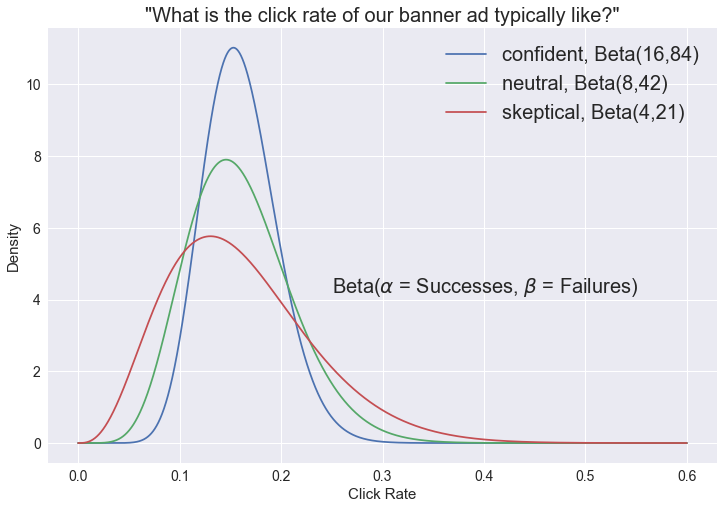

In [2]:
x = np.linspace(0,0.6,5000)   # This will help to plot from 0 to 0.6 on x-axis
y1 = beta.pdf(x,16,84)        # Confident
y2 = beta.pdf(x,8,42)         # Neutral
y3 = beta.pdf(x,4,21)         # skeptical

plt.plot(x, y1, label='confident, Beta(16,84)')
plt.plot(x, y2, label='neutral, Beta(8,42)')
plt.plot(x, y3, label='skeptical, Beta(4,21)')

plt.title('"What is the click rate of our banner ad typically like?"', fontsize=20)
plt.xlabel('Click Rate', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.tick_params(labelsize=14)

plt.annotate(r'Beta($\alpha $ = Successes, $\beta $ = Failures)', 
             xycoords = 'data', 
             xy=(0.25, 4.2), 
             fontsize=20 )

plt.legend(prop={'size': 20})

plt.show()

# We are going to start out the prior assumption 
# that the distribution of click rates for site A and site B
# have Beta distribution with parameters of alpha=8, beta=42

# You could have a uniform distribution for the prior for 0 <= p <= 1

# remember that the beta pdf is scaled in the graph

In [3]:
import numpy as np
np.random.seed(42)

from scipy.stats import beta                        # Beta Distribution
group_size = 1000                                   # 1000 trials in both A and B groups
A_group, B_group = np.random.rand(2, group_size)    # For each group, 1000 values between zero and one

A_successes = sum(A_group < 0.15)                   # Our A variant has true success rate of 15%
B_successes = sum(B_group < 0.20)                   # Our B variant has true success rate of 20%

A_failures = group_size - A_successes               # remaining oberserations would be considerd as failures     
B_failures = group_size - A_successes

A_posterior = beta(A_successes + 8,                 # A_posterior = prior + A's data
                   A_failures  + 42)

B_posterior = beta(B_successes + 8,                 # B_posterior = prior + B's data
                   B_failures  + 42)

My thoughts

1. While I undertand for the sake of the simulation, we already know the true conversation rate for A and B. 

2. I believe that Bayesian approach for A/B testing assumes that we don't know that. 
    1. In other words, under the Bayesian approach, we are supposed to be inferring what the true conversation rate is as we get more samples to consider. 

## Plot the Posterior

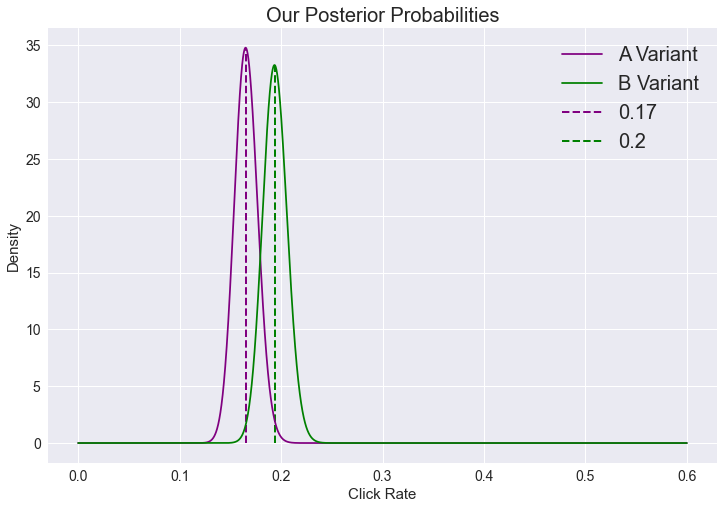

In [4]:
x = np.linspace(0,0.6,5000)  
plt.plot(x, A_posterior.pdf(x), label='A Variant', color='purple')
plt.plot(x, B_posterior.pdf(x), label='B Variant', color='green')

#Plot Median Line
plt.vlines(x=A_posterior.median(), ymin=0, ymax=A_posterior.pdf(A_posterior.median()), 
           colors='purple', ls='--', lw=2, label='%.2f' % A_posterior.median())
plt.vlines(x=B_posterior.median(), ymin=0, ymax=B_posterior.pdf(B_posterior.median()), 
           colors='green', ls='--', lw=2, label='%.1f' % B_posterior.median())


plt.title('Our Posterior Probabilities', fontsize=20)
plt.xlabel('Click Rate', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.tick_params(labelsize=14)


plt.legend(prop={'size': 20})

plt.show()

In [5]:
print("Median Point for A Posterior: (%.5f,%.5f)" % 
      (A_posterior.median(), A_posterior.pdf(A_posterior.median()))
     )
print("Mean Point for A Posterior: (%.5f,%.5f) \n" % 
      (A_posterior.mean(), A_posterior.pdf(A_posterior.mean()))
     )
print("Median Point for B Posterior: (%.5f,%.5f)" % 
      (B_posterior.median(), B_posterior.pdf(B_posterior.median()))
     )
print("Mean Point for B Posterior: (%.5f,%.5f) \n" % 
      (B_posterior.mean(), B_posterior.pdf(B_posterior.mean()))
     )

Median Point for A Posterior: (0.16550,34.77958)
Mean Point for A Posterior: (0.16571,34.74981) 

Median Point for B Posterior: (0.19392,33.26192)
Mean Point for B Posterior: (0.19411,33.24157) 



Since we used 1000 people for each test, the variance of the curve decreased, so we can be relatively confident in these measures.

In [6]:
mean, var = beta.stats(8, 42)
print("Prior Mean for both A & B: %.2f"   % mean) # He used the same for A & B Prior
print("Prior Var for both A & B: %.5f \n" % var )

mean_post_A, var_post_A = A_posterior.stats()
print("Posterior Mean for A: %.2f"   % mean_post_A)
print("Posterior Var for A: %.5f \n" % var_post_A )

mean_post_B, var_post_B = B_posterior.stats()
print("Posterior Mean for B: %.2f"   % mean_post_B)
print("Posterior Var for B: %.5f \n" % var_post_B )

Prior Mean for both A & B: 0.16
Prior Var for both A & B: 0.00264 

Posterior Mean for A: 0.17
Posterior Var for A: 0.00013 

Posterior Mean for B: 0.19
Posterior Var for B: 0.00014 



## Calculate a p-ish value with Monte Carlo Simulation

In [7]:
import pandas as pd

n_trials = 100000                                  #100,000 trials
A_samples = pd.Series([A_posterior.rvs()  
                      for _ in range(n_trials)])   #draw 100k samples from A distribution

B_samples = pd.Series([B_posterior.rvs() 
                      for _ in range(n_trials)])   #draw 100k samples from B distribution

B_wins = sum(B_samples > A_samples)                #how many times did B outperform A?

B_wins / n_trials                                  #percentage of B wins

0.9563

~0.96, which can be likened to a one-side p-value of 0.04

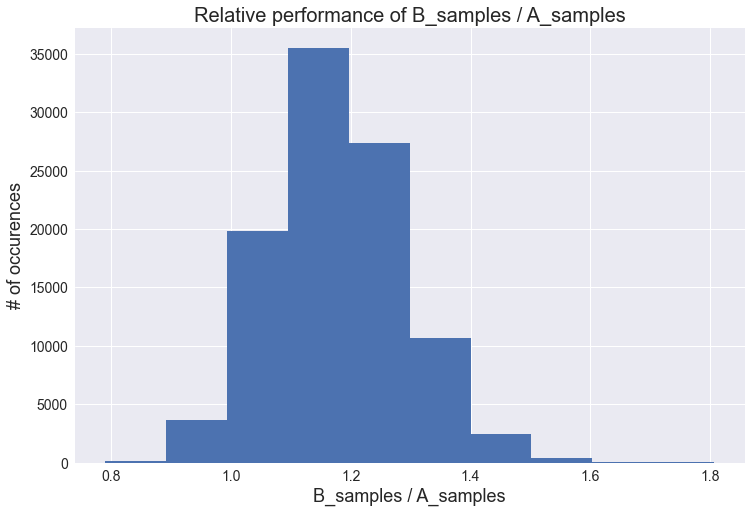

In [8]:
B_relative = B_samples / A_samples
B_relative.hist()

plt.title('Relative performance of B_samples / A_samples', fontsize=20)
plt.xlabel('B_samples / A_samples', fontsize=18)
plt.ylabel('# of occurences', fontsize=18)
plt.tick_params(labelsize=14)

plt.show()

### 1.1 to 1.3x improvement most likely

In [9]:

# return the median 
result1 = B_relative.median() 
  
# Print the result 
print("Median:", result1) 

# return the median 
result2 = B_relative.mean() 
  
# Print the result 
print("Mean: ", result2) 


Median: 1.1714565532798447
Mean:  1.1768475509078142
